In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV

from tensorflow.keras.applications import *
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D

from tensorflow.keras.optimizers import Adam
import os



In [2]:
#configuring gpu memory usage

gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    try:
        # Set a memory limit for the first GPU (assuming at least one GPU is available)
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)])  # Limit to 4GB
        
        # After setting the configuration, list logical GPUs to verify the configuration
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        
        # Print information about the available GPUs and logical GPUs
        print(len(gpus), "Physical GPU(s) available,", len(logical_gpus), "Logical GPU(s) configured.")
        
    except RuntimeError as e:
        # Print any runtime error that occurs during configuration
        print("Error:", e)
else:
    print("No GPU(s) available. TensorFlow cannot use GPU acceleration.")


1 Physical GPU(s) available, 1 Logical GPU(s) configured.


In [1]:
# helper function for plotting model history
def plot_training_history(history):
    
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

## Reading and preparing data for model training, Using ImageDataGenrator from tensorflow to use image augmentations for training. 

In [4]:
df = pd.read_csv("../balanced_data.csv")
df['cancer'] = df['cancer'].astype(str)


In [6]:
cropped_image_names = []
for im in os.listdir('../CroppedDataset2'):
    cropped_image_names.append(im)

In [7]:
df['cropped_image_path'] = cropped_image_names

In [9]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=101)

IMAGE_SIZE = (256, 256)
BATCH_SIZE = 16
NUM_EPOCHS = 50
LEARNING_RATE = 0.001
INPUT_FOLDER = '../CroppedDataset2'

In [10]:
#setting up the training and validation datagenerator objects.

train_datagen = ImageDataGenerator(
    rescale=1./255,             
    rotation_range=20,          
    width_shift_range=0.2,      
    height_shift_range=0.2,     
    shear_range=0.2,            
    zoom_range=0.2,             
    horizontal_flip=True       
)

val_datagen = ImageDataGenerator(rescale=1./255)

In [11]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=INPUT_FOLDER,                 
    x_col='cropped_image_path',                      
    y_col='cancer',                       
    target_size=IMAGE_SIZE,                
    batch_size=16,
    class_mode='binary'                   
)


val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=INPUT_FOLDER,
    x_col='cropped_image_path',
    y_col='cancer',
    target_size=IMAGE_SIZE,
    batch_size=16,
    class_mode='binary'
)

Found 1852 validated image filenames belonging to 2 classes.
Found 464 validated image filenames belonging to 2 classes.


## Model training and evalutation metrics.

In [12]:
base_model = ResNet50V2(weights='imagenet',input_shape=(256,256,3),include_top=False)

for layer in base_model.layers:
    layer.trainable = False

In [13]:
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(256, activation='relu'))
#model.add(Dropout(0.2)) 
model.add(Dense(1,activation='sigmoid'))

optimizer = Adam(learning_rate=LEARNING_RATE)
model.compile(optimizer=optimizer,loss=['binary_crossentropy'],metrics=['accuracy'])

In [14]:
model_history = model.fit(train_generator,epochs=50,validation_data=val_generator,steps_per_epoch=50)

Epoch 1/50
50/50 [==============================] - 16s 231ms/step - loss: 0.9195 - accuracy: 0.5088 - val_loss: 0.8155 - val_accuracy: 0.4914
Epoch 2/50
50/50 [==============================] - 9s 176ms/step - loss: 0.7187 - accuracy: 0.5239 - val_loss: 0.7132 - val_accuracy: 0.5000
Epoch 3/50
50/50 [==============================] - 8s 164ms/step - loss: 0.7115 - accuracy: 0.4800 - val_loss: 0.7153 - val_accuracy: 0.5022
Epoch 4/50
50/50 [==============================] - 8s 154ms/step - loss: 0.7057 - accuracy: 0.5239 - val_loss: 0.7242 - val_accuracy: 0.5151
Epoch 5/50
50/50 [==============================] - 7s 148ms/step - loss: 0.6972 - accuracy: 0.5100 - val_loss: 0.7073 - val_accuracy: 0.4720
Epoch 6/50
50/50 [==============================] - 7s 148ms/step - loss: 0.6960 - accuracy: 0.5213 - val_loss: 0.7114 - val_accuracy: 0.5129
Epoch 7/50
50/50 [==============================] - 7s 148ms/step - loss: 0.6976 - accuracy: 0.5151 - val_loss: 0.7040 - val_accuracy: 0.5151
Epoch

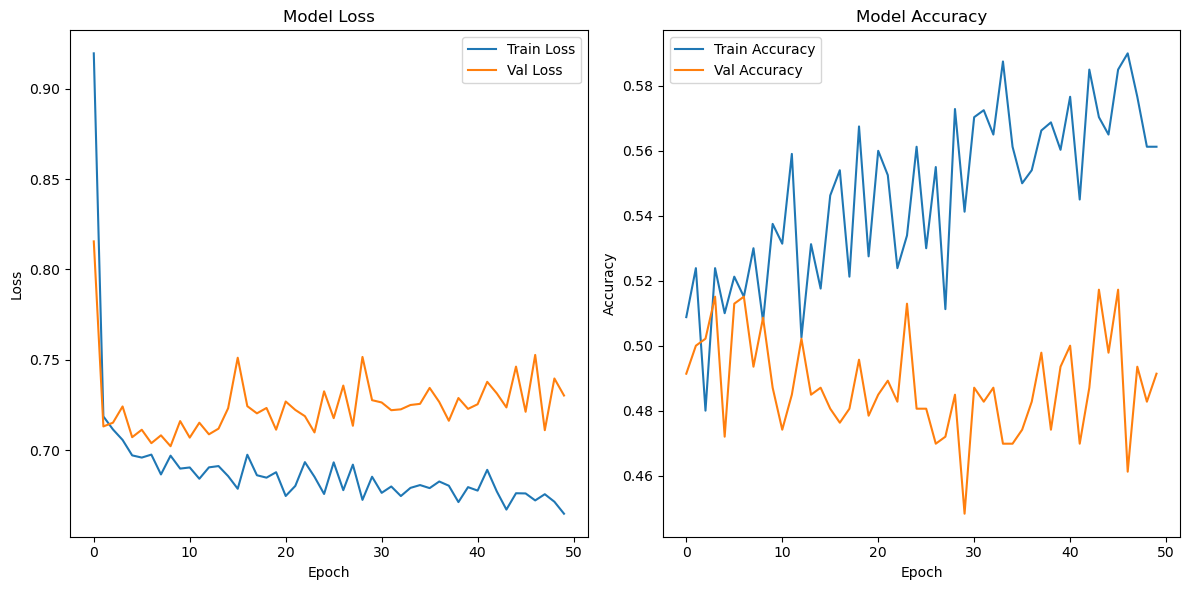

In [15]:
plot_training_history(model_history)

In [16]:
preds_a = (model.predict(val_generator) > 0.5).astype("int32")
y_true = val_generator.classes

29/29 [==============================] - 2s 44ms/step


In [17]:
val_loss, val_accuracy = model.evaluate(val_generator, steps=len(val_generator))

29/29 [==============================] - 1s 32ms/step - loss: 0.7303 - accuracy: 0.4914


In [18]:
from sklearn.metrics import confusion_matrix, accuracy_score,classification_report

In [19]:
class_names = val_generator.class_indices.keys()
report = classification_report(y_true, preds_a, target_names=class_names)

In [20]:
print(report)

              precision    recall  f1-score   support

           0       0.47      0.63      0.54       228
           1       0.46      0.31      0.37       236

    accuracy                           0.47       464
   macro avg       0.46      0.47      0.45       464
weighted avg       0.46      0.47      0.45       464

